In [296]:
from pandas import read_csv
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import scipy.optimize as opt
import pandas as pd
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB, BernoulliNB
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

In [297]:
def clean_data_one_hot(data):
    # replace NaN with mean/mode for numerical and categoriacal
    for col in data.select_dtypes(include=['number']).columns:
        data[col].fillna(data[col].mean(), inplace=True)
    for col in data.select_dtypes(include=['object']).columns:
        data[col].fillna(data[col].mode()[0], inplace=True)
    # create binary columns for each categorical option
    data = pd.get_dummies(
        data=data, 
        columns=list(data.select_dtypes(include=['object']).columns)).astype(int)
    data.drop(['ID'],inplace=True, axis=1)
    return data

def concatenate(df1,df2):
    return pd.concat([df1, df2], axis=1)

def count_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers)

def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

def drop_highly_correlated(data, threshold=0.5):
    correlation_matrix = data.corr().abs()
    upper_triangle = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    highly_correlated_columns = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    data = data.drop(columns=highly_correlated_columns)
    return data

def correlation_matrix_plot(data):
    correlation_matrix = data.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        correlation_matrix, 
        mask=mask, 
        annot=True,
        cmap="coolwarm",
        vmax=1, 
        vmin=-1, 
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75}
    )
    plt.title("Correlation Matrix (Lower Triangle)")
    plt.show()

def strong_correlation_matrix_plot(data, threshold=0.5):
    correlation_matrix = data.corr()
    # Apply threshold to show only strong correlations
    strong_corr = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]
    
    mask = np.triu(np.ones_like(strong_corr, dtype=bool))
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        strong_corr, 
        mask=mask, 
        annot=True, 
        cmap="coolwarm", 
        vmax=1, 
        vmin=-1, 
        center=0, 
        square=True, 
        linewidths=0.5, 
        cbar_kws={"shrink": 0.75}
    )
    plt.title("Strong Correlations (>|{:.1f}|)".format(threshold))
    plt.show()

def logistic_regression_sm(X_train, y_train, X_test):
    # add constant (i.e beta_0 intercept term)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    model = sm.Logit(y_train, X_train)
    result = model.fit()
    # print the summary
    print(result.summary())
    print("Training accuracy:", accuracy_score(y_train, (result.predict(X_train) >= 0.5).astype(int)))
    # predict
    predictions = result.predict(X_test)
    # convert probabilities to binary predictions (0/1)
    binary_predictions = (predictions >= 0.5).astype(int)
    return binary_predictions, model

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost_function(theta, X, y):
    m = len(y)
    predictions = sigmoid(np.dot(X, theta))
    cost = -1/m * (np.dot(y, np.log(predictions)) + np.dot(1 - y, np.log(1 - predictions)))
    gradient = 1/m * np.dot(X.T, (predictions - y))
    return cost, gradient

def logistic_regression(X_train, y_train, X_test):
    # initialize theta (parameters) to zeros
    initial_beta = np.zeros(X_train.shape[1])
    # perform optimization
    result = opt.minimize(fun=cost_function, x0=initial_beta, args=(X_train, y_train), jac=True, method='TNC')
    # Get beta's
    beta_optimal = result.x
    # predict and convert probabilities
    predictions = sigmoid(np.dot(X_test, beta_optimal))
    binary_predictions = (predictions >= 0.5).astype(int)
    return binary_predictions, result
    


def metrics_score(actual, predicted):
    # metric report and plot
    print(classification_report(actual, predicted, digits=3))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, 
                annot=True,  
                fmt='.0f', 
                cmap='Blues', 
                cbar_kws={'label': 'Number of predictions'},
               )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def hist_box(data, col):
    # explore distributions and outliers plot
    f, (ax_box, ax_hist) = plt.subplots(2, 
                                        sharex=True, 
                                        gridspec_kw={'height_ratios': (0.15, 0.85)}, 
                                        figsize=(8,5))
    sns.boxplot(x = data[col], ax=ax_box, showmeans=True)
    sns.distplot(data[col], ax=ax_hist, bins = 45)
    # adding verticle mean/median lines to distplot to match up with boxplot mean/median
    ax_hist.axvline(data[col].median(), c='k', linestyle = 'dashed', label = 'median')
    ax_hist.axvline(data[col].mean(), c = 'g', linestyle = 'dashed', label = 'mean')
    ax_hist.legend(loc = 0, frameon = False, labelcolor = 'linecolor', fontsize = 15)
    # adjustement of label and label size
    ax_hist.set_xlabel(col, fontsize = 14)
    ax_hist.set_ylabel('Density', fontsize = 14)
    plt.show()
    plt.close()
    print(20*'*'+'End of Box+Hist plot for '+ str(col)+20*'*')

In [298]:
train_travel = pd.read_csv('./shinkansen_travel_data/travel_data_train.csv')
train_survey = pd.read_csv('./shinkansen_travel_data/survey_data_train.csv')

In [299]:
# create the mapping dictionary for 'Platform_location' to match the others
platform_to_rest_mapping = {
    'very convinient': 'excellent',
    'Convinient': 'good',
    'manageable': 'acceptable',
    'need improvement': 'need improvement',
    'Inconvinient': 'poor',
    'very inconvinient': 'extremely poor',
}
# replace the values in 'Platform_location' using the mapping dictionary
train_survey['Platform_location'] = train_survey['Platform_location'].map(platform_to_rest_mapping)

In [300]:
# clean data and one hot label encode
train_travel_clean, train_survey_clean = clean_data_one_hot(train_travel), clean_data_one_hot(train_survey)
train_data = concatenate(train_travel_clean, train_survey_clean)
print("All NaN values handled: ", train_data.isnull().sum().sum() == 0)

All NaN values handled:  True


In [301]:
#correlation_matrix_plot(train_data)
#train_travel.info()

In [302]:
class_balance = train_data['Overall_Experience'].value_counts() / train_data['Overall_Experience'].value_counts().sum()
print(f"We have the following class balance in our data:")
print(f"class 1 (satisfied): {round(100*class_balance[1],2)} percent")
print(f"class 0 (disatisfied): {round(100*class_balance[0],2)} percent")

We have the following class balance in our data:
class 1 (satisfied): 54.67 percent
class 0 (disatisfied): 45.33 percent


In [303]:
columns_with_outliers = []
outliers_summary = {}

for column in train_data.columns:
    outlier_count = count_outliers_iqr(train_data, column)
    outliers_summary[column] = outlier_count
    if outlier_count > 20000:  # extreme cases of many outliers (> 20%)
        columns_with_outliers.append(column)

#for col, val in outliers_summary.items():
#    print(col, val)
print("Columns with outliers:", columns_with_outliers)

Columns with outliers: ['Seat_comfort_acceptable', 'Seat_comfort_good', 'Seat_comfort_need improvement', 'Platform_location_good', 'Onboardwifi_service_acceptable', 'Onboardwifi_service_excellent', 'Onboardwifi_service_good', 'Onboard_entertainment_excellent', 'Onboard_service_excellent', 'Online_boarding_acceptable', 'Online_boarding_excellent']


We only remove the most extreme outlier cases since we are dealing with categorical data and some outlier detection might simply be from uneven category counts (i.e. if we have an even number of customers that are happy, neutral or sad, we might calculate a mean of neutral and the happy and sad cases are considered 'outliers'). If we remove some of the outliers for all our categories we will heavily skew towards satisfied customers in our dataset and then BIAS our model to detect these cases mainly. This way we maintain an EVEN split of satisfied and unsatisfied customers in our dataset.

In [304]:
print("Shape before outlier removal: ", train_data.shape)
for column in columns_with_outliers:
    train_data = remove_outliers_iqr(train_data, column)
assert train_data.isnull().sum().sum() == 0
print("Shape after outlier removal: ", train_data.shape)

new_class_balance = train_data['Overall_Experience'].value_counts() / train_data['Overall_Experience'].value_counts().sum()
print(f"We have the following class balance in our data:")
print(f"class 1 (satisfied): {round(100*new_class_balance[1],2)} percent")
print(f"class 0 (disatisfied): {round(100*new_class_balance[0],2)} percent")

Shape before outlier removal:  (94379, 98)
Shape after outlier removal:  (30517, 98)
We have the following class balance in our data:
class 1 (satisfied): 51.35 percent
class 0 (disatisfied): 48.65 percent


In [305]:
y = train_data['Overall_Experience']
X = train_data.drop(['Overall_Experience'], axis=1)
# drop highly correlated columns to reduce feature space
X = drop_highly_correlated(X, threshold=0.7)
print(X.shape)

(30517, 82)


In [306]:
#rank = np.linalg.matrix_rank(X)
#print(f"Rank of the design matrix: {rank}")
#print(f"Number of features: {X.shape[1]}")
## checking for duplicate columns
#duplicate_columns = X.columns[X.columns.duplicated()]
#print(f"Duplicate Columns: {duplicate_columns.tolist()}")
## checking for constant columns
#constant_columns = [col for col in X.columns if X[col].nunique() <= 1]
#print(f"Constant Columns: {constant_columns}")
#X = X.drop(columns=constant_columns)
#print(X.shape)
#
## calculate VIF for each feature
#vif_data = pd.DataFrame()
#vif_data["Feature"] = X.columns
#vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
## drop features with high VIF
#high_vif_features = vif_data[vif_data["VIF"] > 10]["Feature"].tolist()
#X = X.drop(columns=high_vif_features)
## check the updated shape and rank
#print(f"Remaining columns after dropping high VIF features: {X.shape[1]}")
#rank = np.linalg.matrix_rank(X)
#print(f"Rank of the updated design matrix: {rank}")

In [307]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
# split data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# call log reg function from statsmodel
y_preds, lr_model = logistic_regression(X_train, y_train, X_test)

Classification Report for Log Reg:
              precision    recall  f1-score   support

           0      0.869     0.908     0.888      2970
           1      0.909     0.870     0.889      3134

    accuracy                          0.889      6104
   macro avg      0.889     0.889     0.889      6104
weighted avg      0.890     0.889     0.889      6104



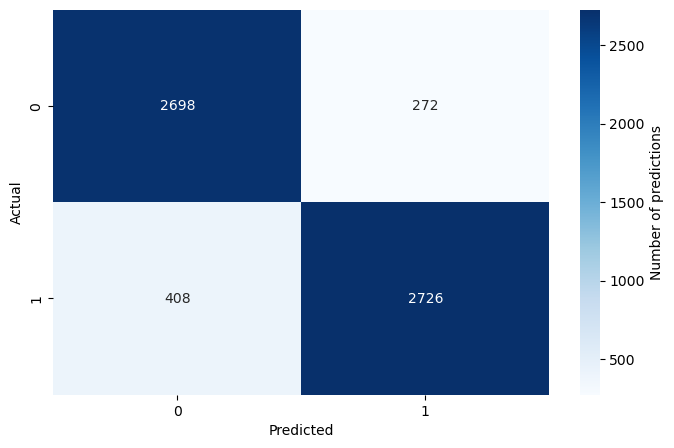

In [308]:
print("Classification Report for Log Reg:")
metrics_score(y_test, y_preds)

Below is a breakdown of the classification report:
1. **Class 0 (Dissatisfied Customer)**:
   - **Precision:** 86.9% of customers predicted as dissatisfied were actually dissatisfied.
   - **Recall:** the model identified 90.8% of the actual dissatisfied customers correctly.
   - **F1-score:** 0.888 shows a strong balance between precision and recall, indicating good performance in identifying dissatisfied customers.

2. **Class 1 (Satisfied Customer)**:
   - **Precision:** 90.9% of customers predicted as satisfied were indeed satisfied.
   - **Recall:** the model identified 87.0% of the actual satisfied customers correctly.
   - **F1-score:** 0.889 reflects solid, balanced performance in predicting satisfied customers as well.

3. **Overall Performance**:
   - **Accuracy:** 88.9% of all predictions were correct, showing strong overall performance.
   - **Macro average** and **weighted average:** indicate consistent performance across both classes without significant bias toward one class over the other.

### Summary:
The metrics suggest that the model is balanced and effective at predicting both classes, which is ideal, especially when there’s a relatively even distribution of the classes in the dataset. Overall, this model provides reliable, well-balanced predictions without significant class imbalance issues.

Training Accuracy: 0.89
Testing Accuracy: 0.89
              precision    recall  f1-score   support

           0      0.879     0.896     0.887      2970
           1      0.899     0.884     0.891      3134

    accuracy                          0.889      6104
   macro avg      0.889     0.890     0.889      6104
weighted avg      0.890     0.889     0.889      6104



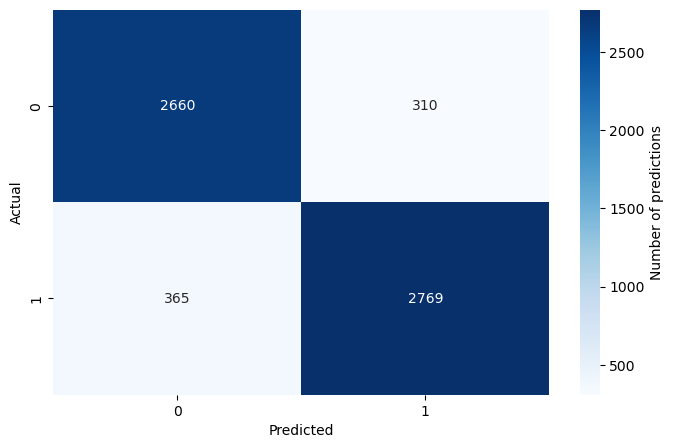

In [241]:
# compare against sklearn
log_reg_cv = LogisticRegressionCV(cv=5, penalty='l2')
log_reg_cv.fit(X_train, y_train)

train_accuracy = log_reg_cv.score(X_train, y_train)
test_accuracy = log_reg_cv.score(X_test, y_test)

print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Testing Accuracy: {test_accuracy:.2f}')

metrics_score(y_test, log_reg_cv.predict(X_test))

The above shows that by adding in L2 (Ridge) regularization along with k-fold cross validation we maintain similer performance. This is because regularization helps in preventing overfitting by penalizing large coefficients, which can make the model more generalizable. However, our dataset already has a clear structure, and our base model seems pretty stable so we may not need regularization. Also, K-fold cross-validation helps to estimate the model’s performance more robustly by testing it on different subsets of the data. Since we do not see much improvement it suggests that our dataset is not particularly noisy or prone to variance. 

In [242]:
# fit Bernoulli Naive Bayes model
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
# pred and eval
y_pred_train = bnb.predict(X_train)
y_pred_test = bnb.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Bernoulli Naive Bayes Train Accuracy: {accuracy_train:.2f}')
print(f'Bernoulli Naive Bayes Test Accuracy: {accuracy_test:.2f}')

Bernoulli Naive Bayes Train Accuracy: 0.85
Bernoulli Naive Bayes Test Accuracy: 0.86


              precision    recall  f1-score   support

           0      0.870     0.838     0.854      2970
           1      0.852     0.881     0.866      3134

    accuracy                          0.860      6104
   macro avg      0.861     0.860     0.860      6104
weighted avg      0.861     0.860     0.860      6104



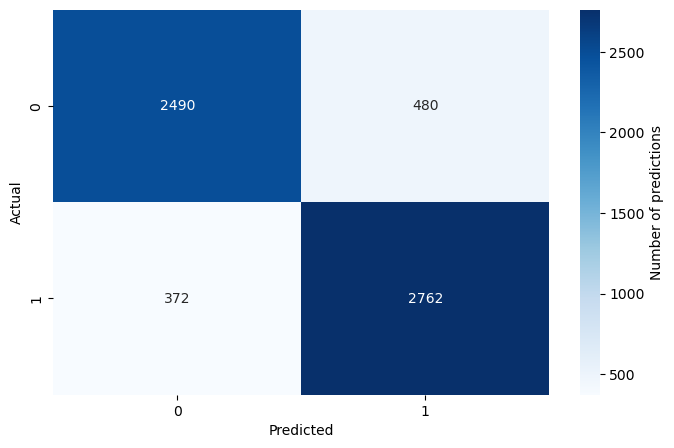

In [243]:
metrics_score(y_test, y_pred_test)

The performance of Naive Bayes is slightly lower than the performance of our logistic regression model however we are still well-balanced in predicting both classes. 

**Potential differences in models:**

Logistic regression assumes a linear relationship between the features and the log-odds of the target class. This means that if the true decision boundary in our data is linear (or close to linear), logistic regression will be a good fit and may out-perform Naive Bayes.
On the other hand, the Naive Bayes assumes that the features are conditionally independent given the class and follows a Bernoulli distribution (binary variables) for each feature. This can be a very strong and often unrealistic assumption, especially if the features are correlated (we drop most highly correlated features but due to one-hot encodng we may still have multicollinearity). Thus due to a few continuous features along with potential dependance in features, the Naive Bayes model might struggle a bit more than Logistic Regression. 